# Prediction of relevant protein kinase-cancer relations
We aim to learn pairs (x,y), where x is a protein kinase and y is a cancer that 
can be effectively treated by inhibiting x. We use word2vec to embed words found
in abstracts from the PubMed corpus; we use [marea](https://github.com/TheJacksonLaboratory/marea) to preprocess PubMed abstracts by replacing words and phrases with concept IDs, followed by analysis with [embiggen](https://pypi.org/project/embiggen/) for word embedding. This notebook imports the embedded vectors and corresponding labels (words) from embiggen. We then extract vectors that correspond to
both protein kinases and cancers. We use a positive set of (x,y) relations that
we have derived from an analysis of Clinical Trials data with [yatcp](https://github.com/monarch-initiative/yactp), and rank other possible protein-kinase cancer relations.

## How to set up this notebook
This notebook depends on the files ``embedding_SG_dim100_upto{year}.npy``, ``words_SG_upto{year}.txt`` (from embiggen), 
``positive_training_upto_{year}.tsv``, ``negative_training_upto_{year].tsv``, ``positive_validation_after_{year}_pahse_4.tsv``, ``negative_prediction_after_{year}_phase_4.tsv`` from the [KCET](https://github.com/TheJacksonLaboratory/KCET) package. For now, the corresponding files are available in
Google drive. Download that folder to someplace on your drive, and then cd to the KCET/notebooks folder,
and softlist the downloaded folder
```
ln -s /path/to/downloaded/folder/ data
```
This notebook assumes it will find the files there.

In [36]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sys.path.insert(0, os.path.abspath('../..'))
from kcet import KinasePredictor

## Input files
``embedding_Skipgram_dim100.npy`` is the result of word2vec embedding of pubmed. ``words.txt`` are the corresponding words. A directory of files was downloaded and softlinked to data using ``ln -s <path> data``.

In [37]:
target_year = 2010
mid_year = 2011
num_years_later = 1

In [38]:
data_directory = '../data/embeddings_final'
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")

embedding_file = os.path.join(data_directory, "embedding_SG_dim100_upto{}.npy".format(target_year))
words_file = os.path.join(data_directory, "words_SG_upto{}.txt".format(target_year))
predictor = KinasePredictor(embeddings=embedding_file, words=words_file)


[INFO] We ingested 195088 labeled word vectors from ../data/embeddings_final/embedding_SG_dim100_upto2010.npy and ../data/embeddings_final/words_SG_upto2010.txt
[INFO] We ingested 522 symbol/NCBI gene id mappings from /Users/ravanv/PycharmProjects/KCET/input/prot_kinase.tsv
[INFO] We ingested 698 meshId/disease mappings from /Users/ravanv/PycharmProjects/KCET/input/neoplasms_labels.tsv



# PubMed Word Embeddings
The following code displays the numbers of word embeddings used as input.

In [39]:
embeddings = predictor.get_embeddings()
embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,-2.641621,3.124869,-4.353377,-2.018315,1.823348,-4.975201,-4.787686,2.649930,-2.948251,-0.916163,...,-1.869853,-3.522519,2.618166,-4.450459,-3.961528,-2.892118,-5.928490,0.367299,-4.532290,2.421597
patient,-3.817505,2.731132,-3.133406,-3.360924,3.251447,-3.779796,-4.411118,2.816041,-5.475833,-2.382731,...,-1.941187,-5.431289,2.350188,-5.862311,-3.625207,-4.146669,-4.293906,0.900865,-4.954704,3.698488
meshd009369,-2.000293,2.692290,-3.906482,-2.403826,2.087734,-4.683461,-4.715221,3.363425,-3.719787,-1.557153,...,-1.572250,-5.367291,2.859295,-5.173111,-5.736109,-3.077639,-3.752953,0.597677,-3.388928,4.321077
study,-3.286283,2.197396,-3.055143,-3.488384,1.583849,-3.476388,-4.572982,2.568147,-4.655032,-2.002333,...,-1.750167,-4.790527,2.999226,-5.209653,-4.173866,-6.466439,-4.163732,0.406401,-3.173547,2.894467
1,-1.973735,2.599354,-4.169664,-2.950947,1.642805,-4.464195,-4.122997,3.285105,-3.085233,-2.332377,...,-1.851673,-4.228116,2.728837,-6.189056,-3.837825,-5.297565,-4.471994,0.961740,-3.943491,3.863080
0,-2.586123,2.689704,-4.212170,-3.771425,1.231912,-4.831149,-4.203139,2.516318,-4.278717,-0.870984,...,-1.646774,-3.917393,3.147377,-6.403146,-3.208885,-4.337939,-5.274619,1.493022,-4.262381,3.811445
case,-2.901989,3.094942,-2.662760,-2.999618,3.339018,-4.174236,-3.733308,3.043080,-5.015265,-2.009101,...,-1.629706,-5.274364,2.490766,-6.020258,-4.223149,-5.065413,-4.717482,1.171679,-4.160813,3.578443
2,-1.995389,2.613357,-4.465601,-3.374403,1.476374,-3.963554,-4.275064,3.415569,-3.165894,-2.673264,...,-1.870650,-4.507325,2.781323,-6.268209,-3.587891,-5.258845,-4.164574,0.931996,-4.031983,3.908941
use,-2.350996,2.471157,-3.943660,-4.285838,1.903959,-3.824636,-5.363203,3.795658,-3.144410,-2.605247,...,-1.496192,-3.672382,3.161894,-3.771332,-5.287291,-5.904677,-6.007619,0.785128,-5.524373,3.306188
treatment,-4.137800,2.313303,-4.491300,-4.538378,2.906991,-3.536086,-5.214668,3.688766,-3.349134,-2.446090,...,-1.661259,-3.453831,2.958672,-6.402697,-2.986871,-6.025044,-3.379093,0.627732,-5.395659,5.521724


In [40]:
print("Total number of embeddings: ", len(embeddings))

Total number of embeddings:  195088


# Positive examples
Note that we need to rename the gene.id to gene_id upstream TODO

In [41]:
positive_examples =  "positive_training_upto_{}.tsv".format(target_year)
positive_df = pd.read_csv(positive_examples,  sep= "\t")[["mesh_id", "gene_id"]]
positive_df.head()

,mesh_id,gene_id
0,meshd015179,ncbigene1956
1,meshd009362,ncbigene1956
2,meshd016609,ncbigene1956
3,meshd008113,ncbigene1956
4,meshd002289,ncbigene1956


In [42]:
print("%d positive examples" % len(positive_df))
print("%d embedded words in total" % len(predictor.get_embeddings()))

161 positive examples
195088 embedded words in total


# Difference vectors
We form difference vectors by substracting the word vectors for the protein kinases (in the column ``gene.id``)
from the corresponding vectors for the cancer (in the column ``mesh_id``). The following function in the
KCET package takes the dataframe shown above, finds the corrresponding vectors, substracts them, and
returns a new Pandas dataframe.

In [43]:
diff_vectors_pos_train = predictor.get_disease_kinase_difference_vectors(examples=positive_df)

[INFO] Extracted 132 kinase-cancer difference vectors
[INFO]	Initial data: 161 examples
[INFO]	Could not identify 1 gene ids
[INFO]	Could not identify 0 MeSH ids


In [44]:
diff_vectors_pos_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1956-meshd015179,-1.758768,0.821506,-0.218957,-0.418908,1.173821,2.282200,-0.896008,0.869499,-0.596625,-1.125477,...,0.244606,-0.978184,-0.364866,-0.861954,2.721985,0.355013,-1.774969,0.447741,0.221942,0.967503
ncbigene1956-meshd009362,-0.488660,-0.127344,1.152679,-1.458963,0.629901,1.370382,-0.432642,-0.060593,-0.768857,-0.831967,...,-0.106943,-2.545844,1.020391,2.764358,0.198052,-1.228320,-2.482996,0.121853,-0.002106,-0.983001
ncbigene1956-meshd016609,1.205292,0.113798,-1.177771,-1.224409,-0.320766,0.655336,-1.157197,1.443528,-1.263317,-1.750137,...,0.342476,-3.346388,-0.123938,-0.298214,0.739539,-0.900963,-2.440659,1.079363,0.378580,-1.017632
ncbigene1956-meshd008113,0.243748,0.850496,-0.247731,-1.412440,-1.462184,3.085130,-1.012596,2.120200,-1.968772,-2.174910,...,0.080879,-2.727978,0.043658,-0.467317,0.111648,0.602614,-2.497726,0.504189,-1.959718,0.611904
ncbigene1956-meshd002289,-0.197365,0.567358,-0.211547,0.391760,0.885465,2.867372,0.110631,1.182542,1.366991,-1.176261,...,0.283839,-0.278417,0.089316,0.738022,1.080370,-0.954275,-1.885794,0.135279,-1.811702,-0.210935


In [45]:
print("%d total difference vectors were extracted." % len(diff_vectors_pos_train))

132 total difference vectors were extracted.


# Negative examples
Here, we process negative examples in the same way. TODO LINK TO EXPLANATION OF HOW WE MAKE POS AND NEG

In [46]:
negative_examples =  "negative_training_upto_{}.tsv".format(target_year)
negative_df = pd.read_csv(negative_examples,  sep= "\t")[["mesh_id", "gene_id"]]
negative_df.head()

,mesh_id,gene_id
0,meshd005770,ncbigene2045
1,meshd007822,ncbigene91754
2,meshd010039,ncbigene29110
3,meshd058922,ncbigene1263
4,meshd016403,ncbigene8805


In [47]:
print("%d negative examples" % len(negative_df))

1350 negative examples


In [48]:
diff_vectors_neg_train = predictor.get_disease_kinase_difference_vectors(examples=negative_df)

[INFO] Extracted 1124 kinase-cancer difference vectors
[INFO]	Initial data: 1350 examples
[INFO]	Could not identify 41 gene ids
[INFO]	Could not identify 48 MeSH ids


In [49]:
diff_vectors_neg_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene2045-meshd005770,0.079102,0.140739,-0.636759,-0.551788,0.285947,-0.862563,-1.081320,0.279698,-1.421246,-0.301845,...,0.024023,-1.032559,0.021355,-1.348079,-0.524308,-0.879363,-0.956672,-0.015384,-0.840487,0.909708
ncbigene91754-meshd007822,1.031886,-0.885862,1.186334,1.182781,0.487590,2.922208,1.119999,-1.449995,2.860540,1.924890,...,1.571640,4.593875,-2.125336,2.581230,1.748546,1.639117,2.620692,-0.438429,1.121155,-2.906359
ncbigene29110-meshd010039,-0.493388,0.137326,-1.870432,-1.928063,1.178215,-0.864682,-1.530044,1.717341,-1.554578,-0.616941,...,-1.231021,-1.500984,0.697842,-1.804156,-0.990704,-1.025167,-1.009895,-0.517425,-0.937564,1.268977
ncbigene1263-meshd058922,1.551042,-0.807235,0.655559,0.325580,0.525500,1.427408,0.321216,-0.274013,1.494982,0.810571,...,0.435590,0.335051,-0.058195,1.230050,0.344783,0.548167,0.011528,-1.138362,0.482162,-0.387847
ncbigene8805-meshd016403,1.368280,-1.090764,0.736213,0.292741,-0.939507,0.527804,0.077326,-0.470190,1.114533,0.449106,...,1.050371,1.032558,-0.770681,0.837487,0.513381,-0.400449,0.674533,-1.140260,0.802441,0.044253


# PCA visualization
To do PCA, we concatenate the positive and negative examples and label them so that we can visualize them using PCA.

In [50]:
X_train = diff_vectors_pos_train.append(diff_vectors_neg_train)
print("[INFO] We combined positive (n=%d) and negative (n=%d) to the combined dataframe (%d)" % 
      (len(diff_vectors_pos_train), len(diff_vectors_neg_train), len(X_train)))

[INFO] We combined positive (n=132) and negative (n=1124) to the combined dataframe (1256)


In [51]:
X_train.values

array([[-1.7587682e+00,  8.2150578e-01, -2.1895671e-01, ...,
         4.4774115e-01,  2.2194195e-01,  9.6750259e-01],
       [-4.8866010e-01, -1.2734413e-01,  1.1526792e+00, ...,
         1.2185264e-01, -2.1064281e-03, -9.8300052e-01],
       [ 1.2052921e+00,  1.1379838e-01, -1.1777706e+00, ...,
         1.0793628e+00,  3.7857962e-01, -1.0176322e+00],
       ...,
       [ 2.5474310e+00, -1.2754434e+00,  2.7958274e-01, ...,
        -1.6827515e+00,  1.2137187e+00, -1.3335419e-01],
       [ 1.9294865e+00, -1.0541983e+00,  1.3356475e+00, ...,
        -5.9849954e-01,  2.7531829e+00, -2.5294318e+00],
       [ 1.0643927e+00, -1.2412397e+00, -2.7100110e-01, ...,
        -1.4443469e+00,  7.9144692e-01, -5.7951689e-02]], dtype=float32)

In [52]:
# vector with colors for the data points -- red for positive, blue for negative
cvec = [ "red" if i < len(diff_vectors_pos_train) else "blue" for i in range(len(X_train))]

In [53]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.6148622  0.05334993 0.03240423]


Text(0, 0.5, 'PC 2 (5.33%)')

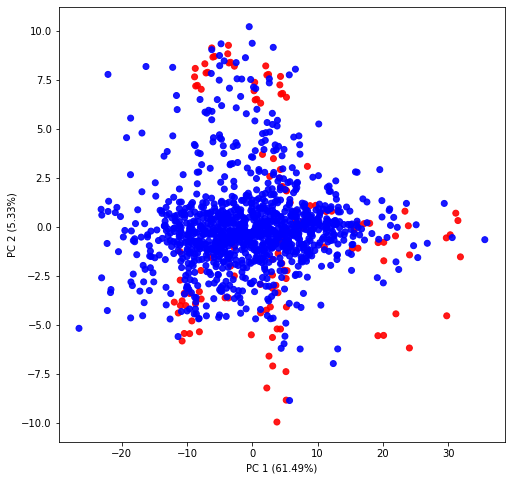

In [54]:
plt.figure(figsize=(8,8))

plt.scatter(pca_result[:,0], pca_result[:,1],c=cvec, alpha=0.9)
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

# T-Distributed Stochastic Neighbouring Entities (t-SNE) Plot

In [55]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1256 samples in 0.001s...
[t-SNE] Computed neighbors for 1256 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1256
[t-SNE] Computed conditional probabilities for sample 1256 / 1256
[t-SNE] Mean sigma: 1.223562
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.523972
[t-SNE] KL divergence after 300 iterations: 0.743467
t-SNE done! Time elapsed: 2.4575750827789307 seconds


Text(0, 0.5, 'tsne-2d-two')

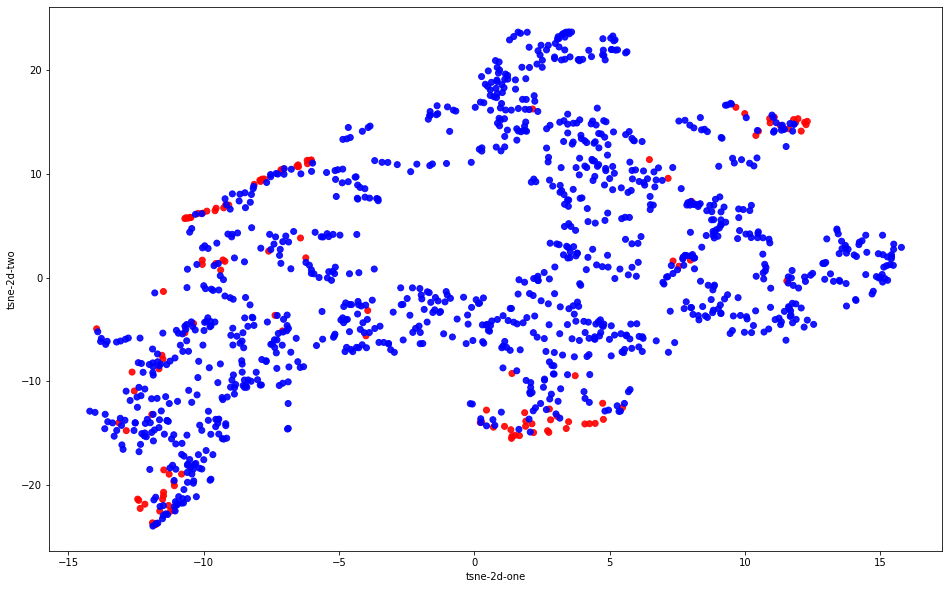

In [56]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cvec,  alpha=0.9)
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two') 

# Random forest
First, let's arrange the training data. X_train we have from above. We additionally need to create a data structure for the labels with 1=positive, 0=negative example

In [57]:
print("Training data dimensions:", X_train.shape)

Training data dimensions: (1256, 100)


In [58]:
label_1 = np.ones(diff_vectors_pos_train.shape[0])
label_0 = np.zeros(diff_vectors_neg_train.shape[0])
Y_train = np.concatenate((label_1,label_0))
n_pos_examples = sum([x for x in Y_train])
n_neg_examples = sum([(1-x) for x in Y_train])
print("Number of positive examples: %d, number of negative examples: %d, Y_train.shape: %s" % (n_pos_examples, n_neg_examples, Y_train.shape))

Number of positive examples: 132, number of negative examples: 1124, Y_train.shape: (1256,)


## Positive validation data
Note that for this pilot experiment, we are not checking ROC, but we are just predicting values for all combinations of protein kinases and cancers

In [59]:
positive_validation_data =  "positive_validation_{}_years_after_{}_target_{}_phase4.tsv".format(num_years_later, mid_year,target_year)
positive_validation_df = pd.read_csv(positive_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [60]:
positive_validation_df.head()

,mesh_id,gene_id
0,meshd018287,ncbigene2475


In [61]:
diff_vectors_pos_validation = predictor.get_disease_kinase_difference_vectors(positive_validation_df)

[INFO] Extracted 1 kinase-cancer difference vectors
[INFO]	Initial data: 1 examples
[INFO]	Could not identify 0 gene ids
[INFO]	Could not identify 0 MeSH ids


In [62]:
diff_vectors_pos_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene2475-meshd018287,0.946715,0.105206,-1.025198,-4.12202,1.281455,-0.322257,-1.842697,0.098851,-0.657799,0.265823,...,-0.144348,1.174294,0.44352,-2.68775,-0.34389,-2.309534,-0.671291,-0.938608,-0.644755,1.395599


## Negative validation data

In [63]:
negative_validation_data = "negative_validation_upto_{}.tsv".format(target_year)
negative_validation_df = pd.read_csv(negative_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [64]:
negative_validation_df.head()

,mesh_id,gene_id
0,meshd002292,ncbigene23043
1,meshd018267,ncbigene124923
2,meshd009808,ncbigene282974
3,meshd015448,ncbigene5585
4,meshd018233,ncbigene6196


In [65]:
diff_vectors_neg_validation = predictor.get_disease_kinase_difference_vectors(negative_validation_df)

[INFO] Extracted 1124 kinase-cancer difference vectors
[INFO]	Initial data: 1350 examples
[INFO]	Could not identify 39 gene ids
[INFO]	Could not identify 51 MeSH ids


In [66]:
diff_vectors_neg_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene23043-meshd002292,-0.834549,0.672809,-0.674461,-0.802152,0.657542,-1.007588,-1.029053,0.769013,-0.899212,-0.750647,...,-0.224458,-0.963294,0.785453,-1.220322,-0.792042,-1.188190,-1.064593,0.638840,-0.937057,0.802853
ncbigene282974-meshd009808,2.022017,-2.399010,1.626751,0.964144,-1.612279,2.831977,2.286835,-1.764282,2.868848,1.080189,...,0.694348,2.370327,-2.073559,3.915266,2.147863,2.769832,2.412228,-0.896132,2.970713,-2.869491
ncbigene5585-meshd015448,1.454981,-0.796124,-0.028030,-1.353254,-0.259218,0.114443,0.408688,0.437267,0.395816,0.893941,...,1.078541,0.866077,-0.751524,0.455683,0.558271,-0.471880,0.690356,-0.617215,0.007386,1.038139
ncbigene6196-meshd018233,1.544548,-0.974132,0.562767,-1.805717,-0.072550,0.331433,-0.322701,0.146774,0.078620,0.516650,...,0.206766,1.129002,0.056130,0.857232,0.314390,0.162922,0.727830,-1.148794,0.397259,-0.338038
ncbigene6355-meshd007945,2.391868,-0.761589,0.585547,-0.250065,-0.653822,1.229138,1.412487,-0.050759,1.401858,2.187510,...,1.197053,2.275759,-1.341348,1.246821,1.928252,0.248796,1.812032,0.153364,1.938789,0.219070


# Save binary versions of the data for use in other notebooks
We 'pickle' the three pandas dataframes produced by the code in this notebook.

In [67]:
positive_valid_diff_pickle_path = "positive-valid-vectors-{}-years-after-{}-target-{}-phase4.pkl".format(num_years_later, mid_year,target_year)
diff_vectors_pos_validation.to_pickle(positive_valid_diff_pickle_path)

In [68]:
positive_train_diff_pickle_path = "positive-train-vectors-{}.pkl".format(target_year)
diff_vectors_pos_train.to_pickle(positive_train_diff_pickle_path)

In [69]:
negative_train_diff_pickle_path = "negative-train-vectors-{}.pkl".format(target_year)
diff_vectors_neg_train.to_pickle(negative_train_diff_pickle_path)

In [70]:
negative_valid_diff_pickle_path = "negative-valid-vectors-{}.pkl".format(target_year)
diff_vectors_neg_validation.to_pickle(negative_valid_diff_pickle_path)